# **Deep Recurrent Q Network with Monte Carlo Tree Search**
Team 7 (Chanhoe Ryu, Sunghwa Ryu, Chulhyun Hwang, Hyunwoo Nam)

Our team had originally planned to simulate safe autonomous driving based on an algorithm introduced in [1] using an autonomous driving simulation framework named SMARTS [2]. However, the framework was more complicated then expected. Instead, we tried to test the proposed algorithm from [1] in CartPole environment.
The algorithm in [2] combines deep recurrent Q network (DRQN) with Monte Carlo tree search (MCTS) to ensure a safe policy. It compares the action selected by DRQN with action selected by MCTS in which stronger constraint on safety was implemented. The latter action is supposed to be safer because of the applied constraint. If the two selected actions were different, the reward for the action selected by DRQN was reduced.

In [1]:
# Install gymnasium to make Cart Pole environment
! pip install gymnasium[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


First we demonstrate a classic DRQN algorithm in the Cart Pole environment. The basis of the algorithm was obtained from a deep Q network (DQN) tutorial of Pytorch, which was then modified to DRQN. [3]

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# Make Cart Pole environment
env = gym.make("CartPole-v1")

# Set up matplotlib to draw graph
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Replay memory

# Tuple to store transition
transition = namedtuple('transition', ('obs', 'action', 'next_obs', 'reward'))

class ReplayMemory(object):
    def __init__(self, size = 200000):
        self.memory = deque([], maxlen=size)

    def store(self, *args):
        self.memory.append(transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
# DRQN
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class DRQN(nn.Module):
    def __init__(self, n_obs, n_actions):
        super(DRQN, self).__init__()
        self.lstm_i_dim = 64    # input dimension of LSTM
        self.lstm_h_dim = 64     # output dimension of LSTM
        self.lstm_n_layer = 1   # number of layers of LSTM
        self.n_actions = n_actions
        self.linear = nn.Linear(n_obs, 64)
        self.flat1 = Flatten()
        self.lstm = nn.LSTM(input_size=self.lstm_i_dim, hidden_size=self.lstm_h_dim, num_layers=self.lstm_n_layer)
        self.fc1 = nn.Linear(self.lstm_h_dim, 64)
        self.fc2 = nn.Linear(64, self.n_actions)

    def forward(self, x, hidden):
        # print(x.shape)
        h1 = F.relu(self.linear(x))
        # print(h1.shape)
        h2 = self.flat1(h1)
        # print(h2.shape)
        h2 = h2.unsqueeze(1)
        # print(h2.shape)
        h3, new_hidden = self.lstm(h2, hidden)
        h4 = F.relu(self.fc1(h3))
        h5 = self.fc2(h4)
        return h5, new_hidden

In [5]:
# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DRQN(n_observations, n_actions).to(device)
target_net = DRQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state, hidden):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            q, new_hidden = policy_net.forward(state.unsqueeze(0), hidden)
            return q[0].max(1)[1].view(1, 1), new_hidden
    else:
        q, new_hidden = policy_net.forward(state.unsqueeze(0), hidden)
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), new_hidden


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch. This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_obs)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_obs
                                                if s is not None])
    state_batch = torch.cat(batch.obs)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    hidden = (Variable(torch.zeros(1, 1, 64).float()), Variable(torch.zeros(1, 1, 64).float()))

    # print(policy_net(state_batch, hidden)[0].transpose(1,2).squeeze().shape)
    # print(action_batch.shape)
    # state_action_values = policy_net(state_batch, hidden)[0].gather(1, action_batch)
    q, hidden = policy_net(state_batch, hidden)
    state_action_values = q.transpose(1,2).squeeze().gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        q, hidden = target_net(non_final_next_states, hidden)
        # print(q.shape)
        # print(q.max(1)[0])
        next_state_values[non_final_mask] = q.transpose(1,2).squeeze().max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


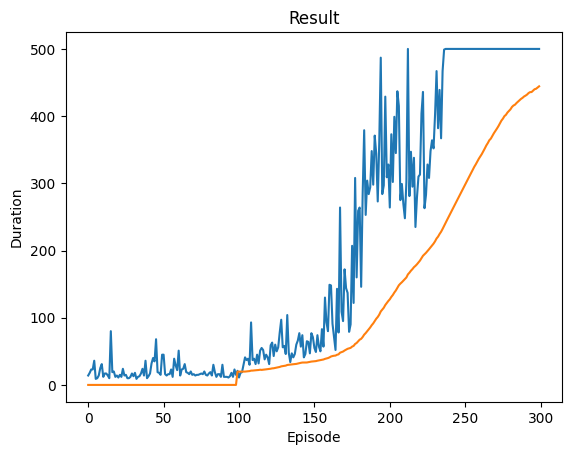

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
num_episodes = 300

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    hidden = (Variable(torch.zeros(1, 1, 64).float()), Variable(torch.zeros(1, 1, 64).float()))
    for t in count():
        action, hidden = select_action(state, hidden)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.store(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Next, we demonstrate DRQN algorithm combined with MCTS.
Hyperparameters for DRQN are the same as the previous DRQN algorithm for comparison.

In [8]:
env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MCTS algorithm is written in the cell below. While it follows the conventional MCTS algorithm, hard constraints on safe policy are applied in the rollout part. Especially in the Cart Pole environment, the rollout is to be terminated if the absolute value of the cart position is larger than 1.2 or the absolute value of the pole angle is greater than 6°. In real Cart Pole environment the termination conditions are 2.4 and 12°respectively. This is to ensure that the action chosen by MCTS is safer than action chosen by DRQN.

In [15]:
# Monte Carlo Tree Search with Upper Confidence Bounds
c = math.sqrt(2)/2
iterations = 20
class Node():
  def __init__(self, depth=-1, parent=None):
    self.children = {}
    self.parent = parent
    self.terminal = False
    self.reward = 0
    self.count = 0.0000001
    self.depth = depth + 1

  def expand(self, iterations, actions):
    if iterations == 0:
      self.terminal = True
    else:
      for a in range(actions.n):
        if a not in self.children.keys():
          self.children[a] = Node(self.depth+1, self)

  def update(self, reward):
    self.count += 1
    self.reward += reward

  def select(self):
    # if self.count < 1:
    #   self.count = 0
    # print(self.children.values)
    am = max(self.children.values(), key=lambda v_prime: v_prime.reward / v_prime.count + c*math.sqrt(2*math.log(self.count)/v_prime.count))
    return am

from copy import deepcopy

def MCTS(root_node, iterations, actions):

  for i in range(iterations):
    node = deepcopy(root_node)
    # print(type(node))
    # Select
    while len(root_node.children) == actions.n and root_node.terminal: # node is fully expanded and non-terminal
        node = node.select()

    # Expand
    if len(root_node.children) != actions.n: # if we can expand
        root_node.expand(iterations - i, actions)

    # Rollout
    exp_env = gym.make("CartPole-v1")
    exp_env.reset()
    d = root_node.depth
    while node.terminal != False:
      random_action = random.choice([0, 1])
      state, step_reward, node.terminal, _ = exp_env.step(random_action)
      # End rollout if hard constraint is violated
      if math.abs(state[0]) > 1.2 or math.abs(state[2]) > 6 :
        break
      d += step_reward

    # Backpropagate
    while node != root_node.parent: # backpropagate from the expanded node and work back to the root node
      node.update(d)
      node = node.parent

    # print(root_node.children)

  # print(sorted(root_node.children, key = lambda c: c.count))
  return [a for a in root_node.children.keys() if root_node.children[a] == max(root_node.children.values(), key = lambda c: c.count)] # return the move that was most visited


In [13]:
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DRQN(n_observations, n_actions).to(device)
target_net = DRQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

episode_durations = []


In [16]:
num_episodes = 300

actions = gym.spaces.Discrete(2)

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    hidden = (Variable(torch.zeros(1, 1, 64).float()), Variable(torch.zeros(1, 1, 64).float()))
    node = Node()
    # print(type(node))
    for t in count():
        risky = False
        drqn_action, hidden = select_action(state, hidden)
        # print(drqn_action)
        mcts_action = MCTS(node, iterations, actions)
        if drqn_action != mcts_action:
          risky = True
        observation, reward, terminated, truncated, _ = env.step(drqn_action.item())
        # print(reward)
        # exit()
        if risky:
          reward -= 0.05
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.store(state, drqn_action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

The training time, as expected, was much longer for DRQN with MCTS. This is not surprising as this algorithm has to perform both DRQN and MCTS.

References
1. Mo, S., Pei, X., & Wu, C. (2021). Safe reinforcement learning for autonomous vehicle using monte carlo tree search. IEEE Transactions on Intelligent Transportation Systems, 23(7), 6766-6773.
2. Zhou, M., Luo, J., Villella, J., Yang, Y., Rusu, D., Miao, J., ... & Wang, J. (2020). Smarts: Scalable multi-agent reinforcement learning training school for autonomous driving. arXiv preprint arXiv:2010.09776.
3. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html